# Taxi Fare Prediction
We train a neural network using PyTorch to predict the fare amount of a taxi ride in New York City given the pickup and dropoff locations, pickup date and time, and the number of passengers.

The data for the analysis is borrowed from a [Kaggle competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction). The TaularModel designed here is based on that of the [fast.ai library](https://docs.fast.ai/tabular.model.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("./taxi-fares.csv")
df.head()

pickup_datetime  fare_amount  ...  dropoff_latitude  passenger_count
0  2010-04-19 08:17:56 UTC          6.5  ...         40.744746                1
1  2010-04-17 15:43:53 UTC          6.9  ...         40.744114                1
2  2010-04-17 11:23:26 UTC         10.1  ...         40.766235                2
3  2010-04-17 02:19:01 UTC         19.7  ...         40.743115                1
4  2010-04-22 08:39:47 UTC          8.1  ...         40.766459                1

[5 rows x 8 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   fare_class         100000 non-null  int64  
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 6.1+ MB


### Timezone Conversion
Since the pickup datetime is in UTC, we convert it to New York timezone.
Then we create the new categorical columns "hour, am-pm, and weekday."

In [4]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]).dt.tz_convert(
    "America/New_York"
)
df["hour"] = df["pickup_datetime"].dt.hour
df["am-pm"] = df["hour"].apply(lambda x: "am" if x < 12 else "pm")
df["weekday"] = df["pickup_datetime"].dt.day_name()
df.head()

pickup_datetime  fare_amount  fare_class  ...  hour  am-pm   weekday
0 2010-04-19 04:17:56-04:00          6.5           0  ...     4     am    Monday
1 2010-04-17 11:43:53-04:00          6.9           0  ...    11     am  Saturday
2 2010-04-17 07:23:26-04:00         10.1           1  ...     7     am  Saturday
3 2010-04-16 22:19:01-04:00         19.7           1  ...    22     pm    Friday
4 2010-04-22 04:39:47-04:00          8.1           0  ...     4     am  Thursday

[5 rows x 11 columns]

In [5]:
df["fare_amount"].describe()

count    100000.000000
mean         10.032964
std           7.501012
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

The fare amount which we would like to predict has the median $\$7.70$ in our data set.

## Measuring the Great-Circle Distance
![Latitude and Longtitude](./graphic-latitude-longitude.png)

(Image source: [HandWiki](https://handwiki.org/wiki/Earth:Latitude))
### Degrees to Radians Conversion
The pickup and dropoff coordinates are measured in degrees. We convert them into radians to measure their sine and cosine values with Numpy below.

In [6]:
coordinates = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
]
for col in coordinates:
    df[col] = np.deg2rad(df[col])

Next we use the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to define a function that returns the (geodesic) distance between pickup and dropoff locations in kilometers. 

$$ 
d = 2R\arcsin\left(
\sqrt{
\sin^2\left(\frac{\phi_2-\phi_1}{2}\right) +
\cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\lambda_2-\lambda_1}{2}\right)
}
\right)
$$

where $R$ is the average radius of the Earth, and $(\phi_1, \lambda_1)$ and $(\phi_2, \lambda_2)$ are the coordinates of the pickup and dropoff locations.

In [7]:
def geo_dist(lat1, long1, lat2, long2):
    R = 6371  # average radius of the Earth in km
    x = (
        np.sin((lat1 - lat2) / 2) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin((long1 - long2) / 2) ** 2
    )
    dist = 2 * R * np.arcsin(np.sqrt(x))
    return dist

In [8]:
df["dist"] = geo_dist(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"],
)
df.head()

pickup_datetime  fare_amount  fare_class  ...  am-pm   weekday      dist
0 2010-04-19 04:17:56-04:00          6.5           0  ...     am    Monday  2.126312
1 2010-04-17 11:43:53-04:00          6.9           0  ...     am  Saturday  1.392307
2 2010-04-17 07:23:26-04:00         10.1           1  ...     am  Saturday  3.326763
3 2010-04-16 22:19:01-04:00         19.7           1  ...     pm    Friday  7.231321
4 2010-04-22 04:39:47-04:00          8.1           0  ...     am  Thursday  1.958574

[5 rows x 12 columns]

### Selecting Continuous and Categorical Features

Our continuous features consist of the pickup and dropoff locations (i.e., coordinates) together with the distance between them. For categorical columns, we choose hour, am-pm, weekday, and passenger count of the ride.

In [9]:
cont_cols = coordinates + ["dist"]
cat_cols = ["hour", "am-pm", "weekday", "passenger_count"]

In [10]:
for col in cat_cols:
    df[col] = df[col].astype("category")

In [11]:
conts = np.column_stack([df[col].values for col in cont_cols])
conts = torch.from_numpy(conts).type(torch.float)

cats = np.column_stack([df[col].cat.codes.values for col in cat_cols])
cats = torch.from_numpy(cats).type(torch.int64)

y = torch.from_numpy(df["fare_amount"].values).type(torch.float).reshape(-1, 1)

In [12]:
conts

tensor([[-1.2914,  0.7109, -1.2911,  0.7111,  2.1263],
        [-1.2914,  0.7111, -1.2911,  0.7111,  1.3923],
        [-1.2914,  0.7112, -1.2908,  0.7115,  3.3268],
        ...,
        [-1.2913,  0.7112, -1.2917,  0.7105,  5.0525],
        [-1.2916,  0.7108, -1.2914,  0.7109,  1.2089],
        [-1.2908,  0.7116, -1.2910,  0.7114,  1.4274]])

In [13]:
cats

tensor([[ 4,  0,  1,  0],
        [11,  0,  2,  0],
        [ 7,  0,  2,  1],
        ...,
        [14,  1,  3,  2],
        [ 4,  0,  5,  0],
        [12,  1,  2,  2]])

In [14]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

### Embedding Sizes
The [fast.ai library](https://docs.fast.ai/tabular.model.html) suggests picking the lower of two values below for the embedding size corresponding to n_cat:
+ A dimension space of 600
+ A dimension space equal to 1.6 times the cardinality of the variable to 0.56.

In [15]:
n_cats = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(n_cat, min(600, round(1.6 * n_cat**0.56))) for n_cat in n_cats]
emb_szs

[(24, 9), (2, 2), (7, 5), (5, 4)]

## Neural Network Model

In [16]:
class TabularModel(nn.Module):
    def __init__(
        self,
        emb_szs,  # list of (num_embeddings, embedding_dim) for each categorical variable
        n_cont,  # number of continuous variables
        out_sz,
        layer_szs,  # input/output size of layers
        p=0.5,  # dropout probability
    ):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(*size) for size in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.cont_bn = nn.BatchNorm1d(n_cont)

        n_emb = sum(emb.embedding_dim for emb in self.embeds)
        in_sz = n_emb + n_cont

        layers = []
        for size in layer_szs:
            layers.append(nn.Linear(in_sz, size))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(p))
            in_sz = size
        layers.append(nn.Linear(layer_szs[-1], out_sz))

        self.layers = nn.Sequential(*layers)

    def forward(self, x_cat, x_cont):
        # find the embeddings of the categorical variables
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeds)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)

        x_cont = self.cont_bn(x_cont)
        x = torch.cat((x, x_cont), 1)
        return self.layers(x)

In [17]:
model = TabularModel(emb_szs, n_cont=conts.shape[1], out_sz=1, layer_szs=[200, 200])

In [18]:
# The RMSE loss will be used when training the model.
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train|Test Split of Data
Since our data is shuffled, we simply pick a test size and do the split manually.

In [19]:
test_prop = 0.1
test_sz = int(len(df) * test_prop)
cat_test, cont_test, y_test = cats[:test_sz], conts[:test_sz], y[:test_sz]
cat_train, cont_train, y_train = cats[test_sz:], conts[test_sz:], y[test_sz:]

## Training the Model

In [20]:
num_epochs = 500
log_epochs = 20
losses = []

for epoch in range(num_epochs):
    y_pred = model(cat_train, cont_train)
    loss = torch.sqrt(loss_fn(y_pred, y_train))
    losses.append(loss.item())
    if epoch % log_epochs == 0:
        print(f"Epoch: {epoch:3}, RMSE Loss: {loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Print the last loss if it's not already displayed.
if (num_epochs - 1) % log_epochs:
    print(f"Epoch: {epoch:3}, RMSE Loss: {loss.item()}")

Epoch:   0, RMSE Loss: 12.533429145812988
Epoch:  20, RMSE Loss: 10.700265884399414
Epoch:  40, RMSE Loss: 10.237874031066895
Epoch:  60, RMSE Loss: 9.863938331604004
Epoch:  80, RMSE Loss: 9.307476997375488
Epoch: 100, RMSE Loss: 8.448710441589355
Epoch: 120, RMSE Loss: 7.260026931762695
Epoch: 140, RMSE Loss: 5.917623043060303
Epoch: 160, RMSE Loss: 4.78204345703125
Epoch: 180, RMSE Loss: 4.295350074768066
Epoch: 200, RMSE Loss: 4.169572830200195
Epoch: 220, RMSE Loss: 4.076566696166992
Epoch: 240, RMSE Loss: 3.9923324584960938
Epoch: 260, RMSE Loss: 3.9172236919403076
Epoch: 280, RMSE Loss: 3.8740286827087402
Epoch: 300, RMSE Loss: 3.8270866870880127
Epoch: 320, RMSE Loss: 3.767500400543213
Epoch: 340, RMSE Loss: 3.691037178039551
Epoch: 360, RMSE Loss: 3.6752266883850098
Epoch: 380, RMSE Loss: 3.6512913703918457
Epoch: 400, RMSE Loss: 3.6154441833496094
Epoch: 420, RMSE Loss: 3.5917937755584717
Epoch: 440, RMSE Loss: 3.5625650882720947
Epoch: 460, RMSE Loss: 3.5153911113739014
Epoc

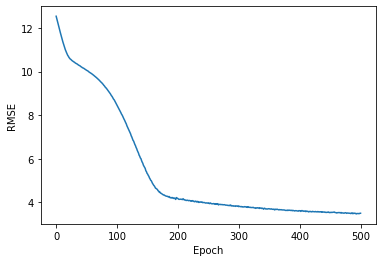

In [21]:
plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.show()

## Conclusion
On average, our predicted values are within $\$3.50$ of the true fares.

## Validating the Model

In [22]:
with torch.no_grad():
    y_pred = model(cat_test, cont_test)
    loss = torch.sqrt(loss_fn(y_pred, y_test))
print("RMSE on validation set is", loss.item())

RMSE on validation set is 3.447754383087158


## Saving the Model

In [23]:
torch.save(model.state_dict(), "taxi-fare-model.pt")